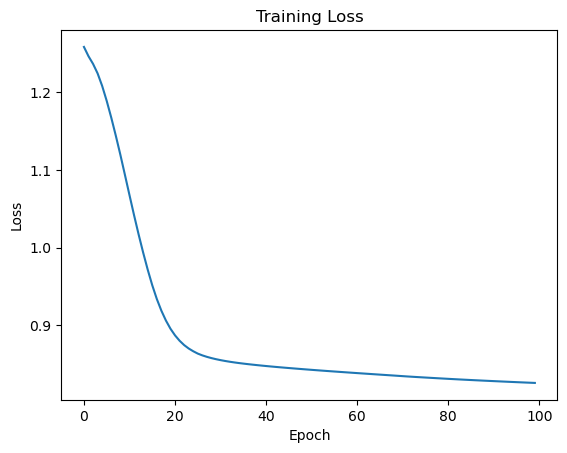

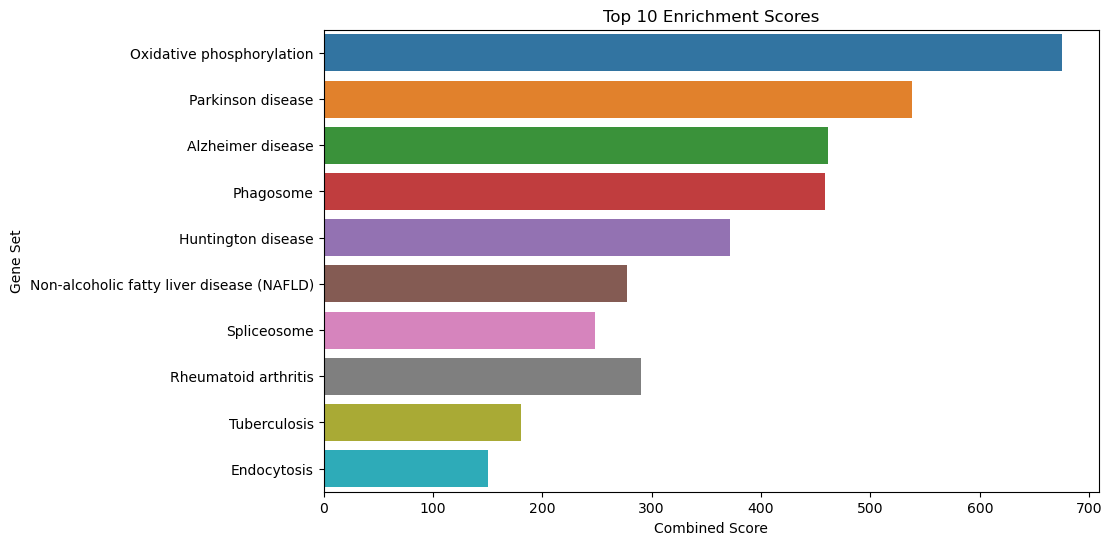

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Oxidative phosphorylation,47/133,9.590044e-28,2.646852e-25,0,0,10.846507,674.779159,COX7B;NDUFB8;NDUFB7;NDUFA11;UQCRB;NDUFA12;NDUF...
1,KEGG_2019_Human,Parkinson disease,46/142,2.577361e-25,3.556758e-23,0,0,9.494934,537.582835,COX7B;NDUFB8;NDUFB7;NDUFA11;UQCRB;NDUFA12;NDUF...
2,KEGG_2019_Human,Alzheimer disease,50/171,4.160254e-25,3.827434e-23,0,0,8.211831,461.004414,COX7B;NDUFA11;NDUFA12;COX4I1;ATP2A2;UQCRFS1;AD...
3,KEGG_2019_Human,Phagosome,46/152,6.710874e-24,4.630503e-22,0,0,8.594636,458.595293,RAB5C;TFRC;NCF2;NCF4;ITGB2;TCIRG1;CORO1A;CTSS;...
4,KEGG_2019_Human,Huntington disease,51/193,2.360566e-23,1.303033e-21,0,0,7.136927,371.837858,COX7B;NDUFA11;NDUFA12;COX4I1;CLTC;CLTB;CLTA;UQ...
5,KEGG_2019_Human,Non-alcoholic fatty liver disease (NAFLD),39/149,5.262051e-18,2.420543e-16,0,0,6.969161,277.275111,COX7B;NDUFB8;NDUFB7;NDUFA11;UQCRB;NDUFA12;NDUF...
6,KEGG_2019_Human,Spliceosome,35/134,2.885848e-16,1.137849e-14,0,0,6.924530,247.770375,SF3B5;RBM25;RBM8A;SF3B6;EIF4A3;HNRNPU;SNU13;SN...
7,KEGG_2019_Human,Rheumatoid arthritis,28/91,2.797664e-15,9.651940e-14,0,0,8.658893,290.159448,CD86;ITGB2;TCIRG1;TNFSF13B;ICAM1;HLA-DMA;HLA-D...
8,KEGG_2019_Human,Tuberculosis,39/179,4.291000e-15,1.315907e-13,0,0,5.467073,180.863112,CEBPB;RAB5C;ITGB2;TCIRG1;CORO1A;CTSS;FCGR3A;HL...
9,KEGG_2019_Human,Endocytosis,46/244,4.993984e-15,1.378340e-13,0,0,4.578765,150.781202,VPS29;RAB5C;TFRC;WIPF1;SH3KBP1;ARPC1B;CLTC;ARP...


In [6]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp

# Load and preprocess the input data
def process_input_data(file_path):
    # Read the data, assuming 'GeneSymbol' is the first column
    data = pd.read_csv(file_path)
    
    # Set 'GeneSymbol' as the index
    data.set_index('GeneSymbol', inplace=True)
    
    # Standardize the numeric data
    processed_data = data.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
    
    return processed_data

# Define the autoencoder model
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Run the autoencoder model
def run_autoencoder(df, hidden_dim=10):
    input_data = torch.tensor(df.values, dtype=torch.float32)
    input_dim = input_data.shape[1]
    model = SimpleAutoencoder(input_dim, hidden_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    losses = []
    num_epochs = 100
    for epoch in range(num_epochs):
        encoded, decoded = model(input_data)
        loss = criterion(decoded, input_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    latent_features = encoded.detach().numpy()
    decoded_features = decoded.detach().numpy()
    
    # Map the latent features and decoded features back to the GeneSymbol index
    latent_features_df = pd.DataFrame(latent_features, index=df.index, columns=[f'Latent_{i+1}' for i in range(hidden_dim)])
    decoded_features_df = pd.DataFrame(decoded_features, index=df.index, columns=df.columns)
    
    # Plot the training loss
    plt.figure()
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    return latent_features_df, decoded_features_df

# Run GSEApy analysis
def run_gseapy_analysis(gene_approximations_df):
    # Select the top contributing genes for GSEA (e.g., by variance)
    top_genes = gene_approximations_df.var(axis=1).nlargest(1000).index.tolist()
    
    # Perform GSEApy analysis
    gsea_results = gp.enrichr(
        gene_list=top_genes,
        gene_sets='KEGG_2019_Human',
        outdir=None  # No output files
    )
    
    # Display the top 10 enrichment scores
    top_10_results = gsea_results.res2d.head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Combined Score', y='Term', data=top_10_results)
    plt.title('Top 10 Enrichment Scores')
    plt.xlabel('Combined Score')
    plt.ylabel('Gene Set')
    plt.show()
    
    return gsea_results.res2d

# Example usage in a Jupyter Notebook
if __name__ == "__main__":
    # Replace with the path to your CSV file
    file_path = 'test_data/merged_dataframe.csv'
    
    # Process the input data
    processed_data = process_input_data(file_path)
    
    # Run the autoencoder
    latent_features_df, decoded_features_df = run_autoencoder(processed_data)
    
    # Run GSEApy analysis
    gseapy_results = run_gseapy_analysis(decoded_features_df)
    
    # Display the top enrichment results
    display(gseapy_results.head(10))